## Ejercicios de pair programming 26 enero: Decision Tree

In [1]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

### Info columnas
|Columna| Tipo de dato | Descripcion |
|-------|--------------|-------------|
|Region| String|	Name of the region.
|WRI	| Decimal |	World Risk Score of the region.
|Exposure	| Decimal |	Risk/exposure to natural hazards such as earthquakes, hurricanes, floods, droughts, and sea ​​level rise.
|Vulnerability	| Decimal |	Vulnerability depending on infrastructure, nutrition, housing situation, and economic framework conditions.
|Susceptibility	| Decimal |	Susceptibility depending on infrastructure, nutrition, housing situation, and economic framework conditions.
|Lack of Coping Capabilities	| Decimal |	Coping capacities in dependence of governance, preparedness and early warning, medical care, and social and material security.
|Lack of Adaptive Capacities| Decimal |	Adaptive capacities related to coming natural events, climate change, and other challenges.
|Year	| Decimal |	Year data is being described.
|WRI Category| String|	WRI Category for the given WRI Score.
|Exposure Category| String|	Exposure Category for the given Exposure Score.
|Vulnerability Categoy| String|	Vulnerability Category for the given Vulnerability Score.
|Susceptibility Category| String|	Susceptibility Category for the given Susceptibility Score.

Link a la base de datos : https://www.kaggle.com/datasets/tr1gg3rtrash/global-disaster-risk-index-time-series-dataset

### Nuestra variable respuesta es Exposure_Sklearn, queremos saber cual es el riesgo de desastres naturales dependiendo del resto de variables



---

### df limpio

---

In [2]:
df = pd.read_csv("../datos/encoding.csv", index_col = 0)
df.head(2)

,region,exposure_category,wri_category,vulnerability_category,susceptibility_category,wri,exposure,vulnerability,susceptibility,lack_of_coping_capabilities,lack_of_adaptive_capacities,year,exposure_Sklearn,wri_categorymap,susceptibility_categorymap,exposure_categorymap,vulnerability_categorymap
0,Papua-Neuguinea,Very High,Very High,Very High,Very High,2.906480,23.26,1.296928,1.179006,0.962932,1.537045,2011.0,0.895683,5,5,5,5
1,Madagaskar,Very High,Very High,Very High,Very High,2.594391,20.68,1.545395,2.260942,1.017385,0.974085,2011.0,0.792566,5,5,5,5


In [3]:
#Definimos x, eliminamos las variables categóricas y la variable respuesta y la y con la variable respuesta
X = df.drop(['region', 'exposure_category', 'wri_category','vulnerability_category', 'susceptibility_category', 'exposure', 'exposure_Sklearn' ], axis = 1)
y = df["exposure_Sklearn"]

In [4]:
#Vamos a dividir nuestras variables de train y test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [6]:
# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeRegressor(random_state =0)

# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train, y_train)



DecisionTreeRegressor(random_state=0)

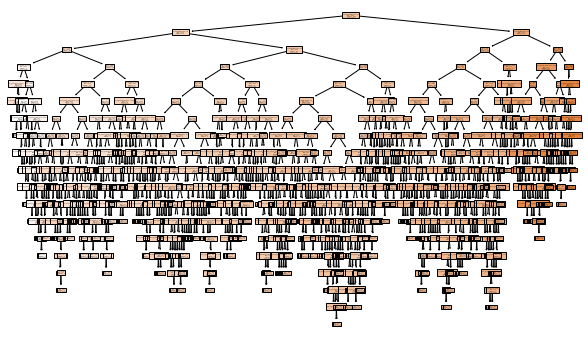

In [7]:
fig = plt.figure(figsize = (10,6))
tree.plot_tree(arbol, feature_names = x_train.columns, filled = True)
plt.show()

Vemos que nuestro *decision tree* es *overfitting* por lo cual probaremos los diferentes hiperparámetros. 

In [8]:
max_features = np.sqrt(len(x_train.columns))
max_features

3.1622776601683795

Nos quedamos con 3

In [9]:
# profundidad de 18

print(arbol.tree_.max_depth)

18


In [10]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [11]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [12]:
dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,1.095147e-02,5.424118e-04,2.328974e-02,0.983011,test,Decission Tree I
1,2.218004e-18,1.745198e-34,1.321059e-17,1.000000,train,Decission Tree I


El modelo está *overfitting* por lo cual decidimos reducir la profundidad y el *max_features*

In [14]:
df.shape

(1706, 17)

In [26]:
param = {"max_depth": [2,4,9], # la profundidad de nuestro arbol es de 18 por lo cual nos quedamos con la mitad y 2 valores mas pequeños.
        "max_features": [1,2,3], # hemos calculado la raiz cuadrada de las variablñes predictoras y era 3,2 así que nos quedamos con 3 como maximo
        "min_samples_split": [10, 50, 100], #hemos calculado el numero de filas de nuestro fichero, 1706, por lo cual nos quedamos con un 100 como maximo.
        "min_samples_leaf": [10,50,100]} 

In [31]:
gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param,
            cv=10, 
            verbose=-1, 
            return_train_score = True, 
            scoring="neg_mean_squared_error") 

In [32]:
gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 9], 'max_features': [1, 2, 3],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [18]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=9, max_features=3, min_samples_leaf=10,
                      min_samples_split=10)

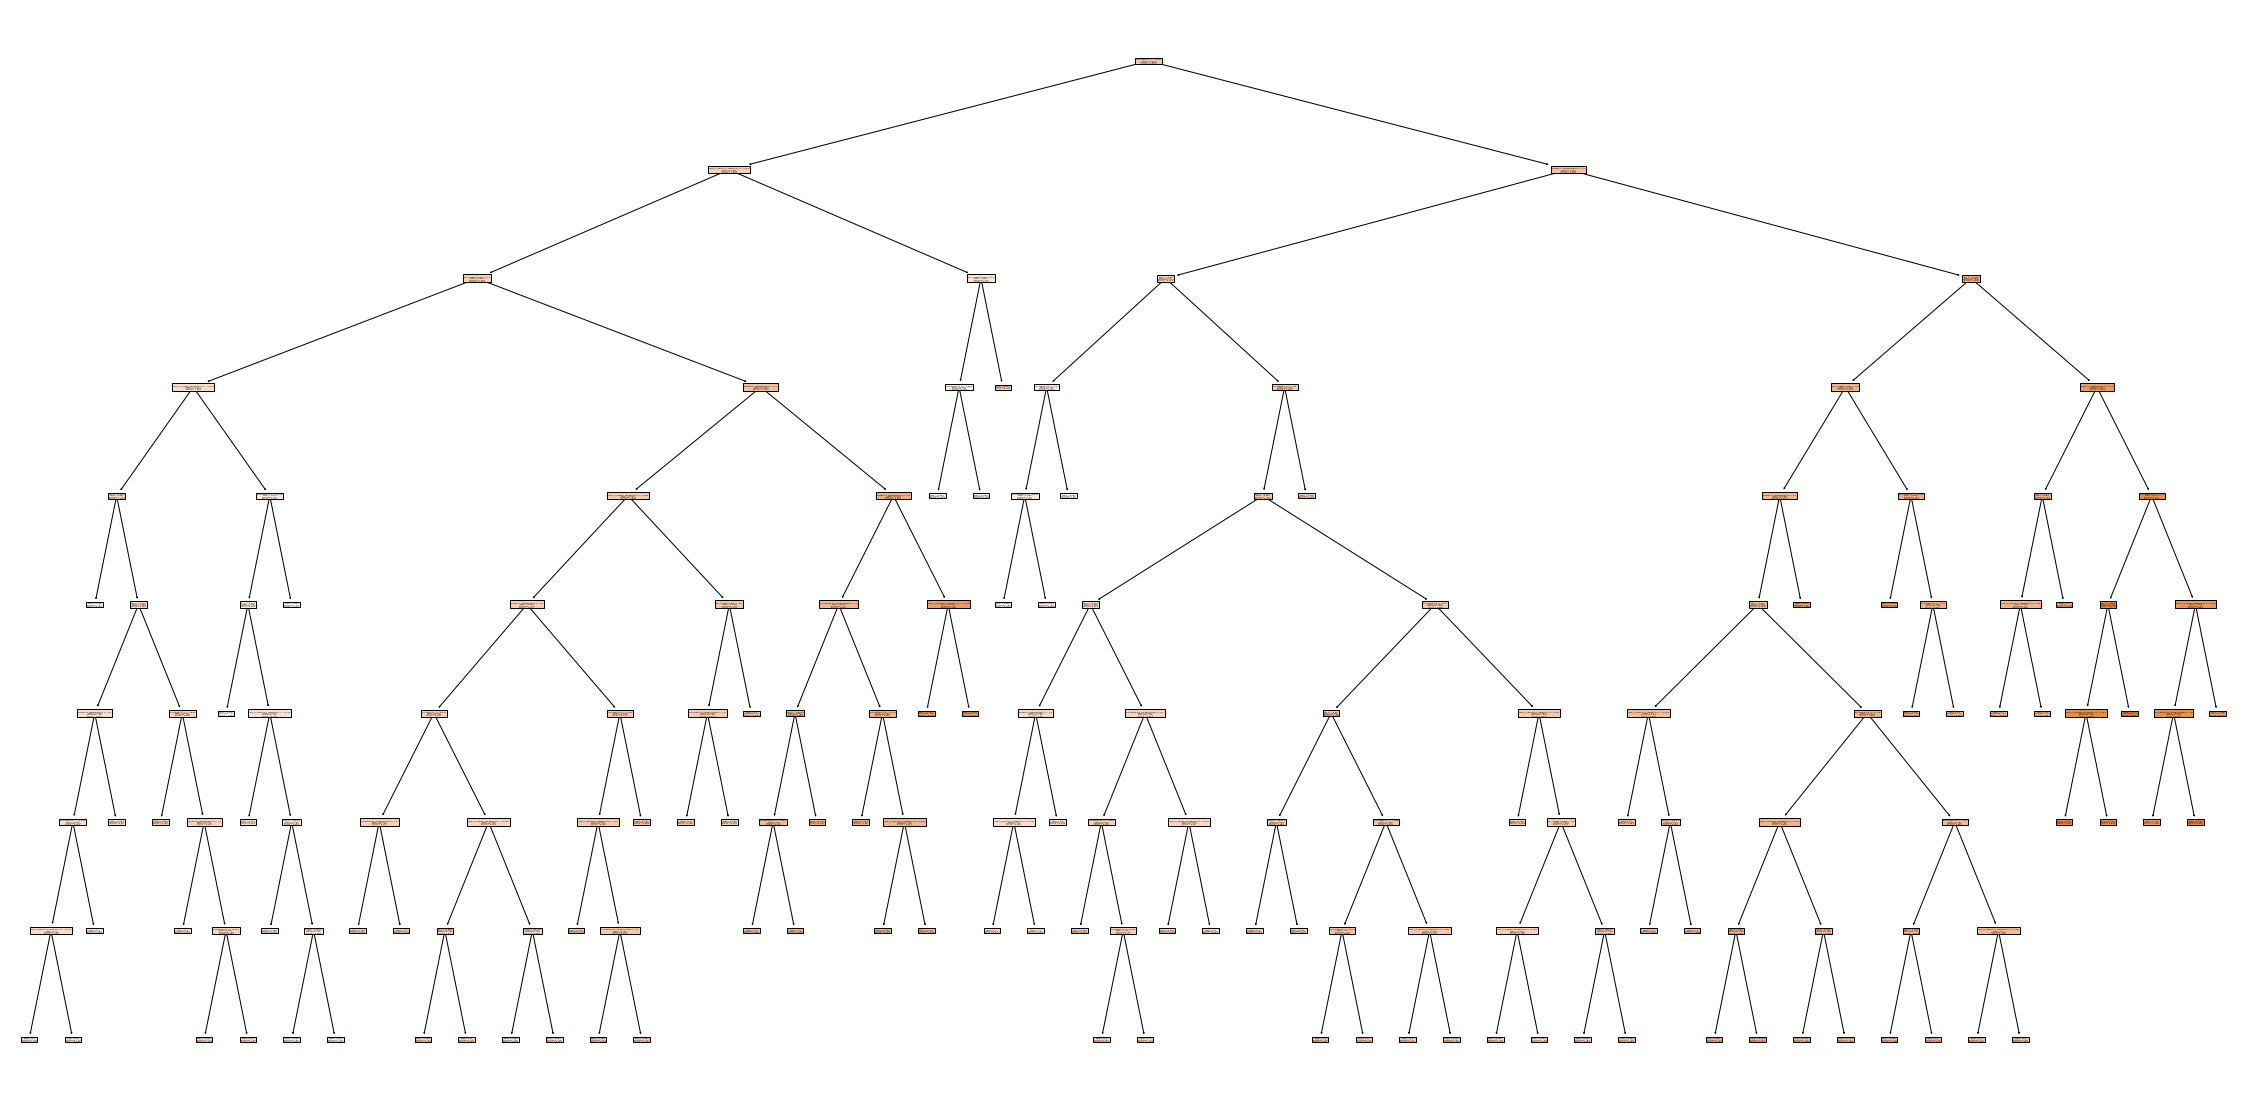

In [19]:
fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train.columns, filled=True);

In [20]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

In [21]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2



,MAE,MSE,RMSE,R2,set,modelo
0,0.031987,0.001978,0.044472,0.938053,test,Decision tree II
1,0.026642,0.001431,0.037835,0.957082,train,Decision tree II


In [22]:
df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,1.095147e-02,5.424118e-04,2.328974e-02,0.983011,test,Decission Tree I
1,2.218004e-18,1.745198e-34,1.321059e-17,1.000000,train,Decission Tree I
0,3.198716e-02,1.977779e-03,4.447222e-02,0.938053,test,Decision tree II
1,2.664228e-02,1.431497e-03,3.783513e-02,0.957082,train,Decision tree II


In [23]:

importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores


Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
8,exposure_categorymap,0.461942
0,wri,0.177520
6,wri_categorymap,0.170919
1,vulnerability,0.127106
3,lack_of_coping_capabilities,0.029062
4,lack_of_adaptive_capacities,0.017565
7,susceptibility_categorymap,0.007177
2,susceptibility,0.006595
5,year,0.001897
9,vulnerability_categorymap,0.000217


/Users/admin/opt/anaconda3/lib/python3.9/site-packages/seaborn/palettes.py:443: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


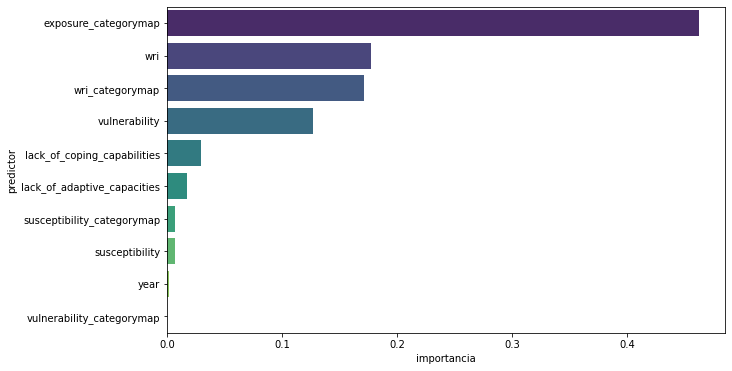

In [24]:
plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()

Hemos visto que nuestro modelo está un poco *overfitting* y hemos decidido volver a ajustar la profundidad para que nos salga un valor mas correcto.

In [27]:
param_1 = {"max_depth": [5,6,7,8], # hemos cambiado la profundidad de nuestro arbol y hemos puesto 4 posibilidades mas pequeñas de 9.
        "max_features": [1,2,3], # hemos calculado la raiz cuadrada de las variablñes predictoras y era 3,2 así que nos quedamos con 3 como maximo
        "min_samples_split": [10, 50, 100], #hemos calculado el numero de filas de nuestro fichero, 1706, por lo cual nos quedamos con un 100 como maximo.
        "min_samples_leaf": [10,50,100]} 

In [33]:
gs_1 = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param_1,
            cv=10, 
            verbose=-1, 
            return_train_score = True, 
            scoring="neg_mean_squared_error") 

In [34]:
gs_1.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [5, 6, 7, 8], 'max_features': [1, 2, 3],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [35]:
mejor_modelo_1 = gs_1.best_estimator_
mejor_modelo_1

DecisionTreeRegressor(max_depth=7, max_features=3, min_samples_leaf=10,
                      min_samples_split=10)

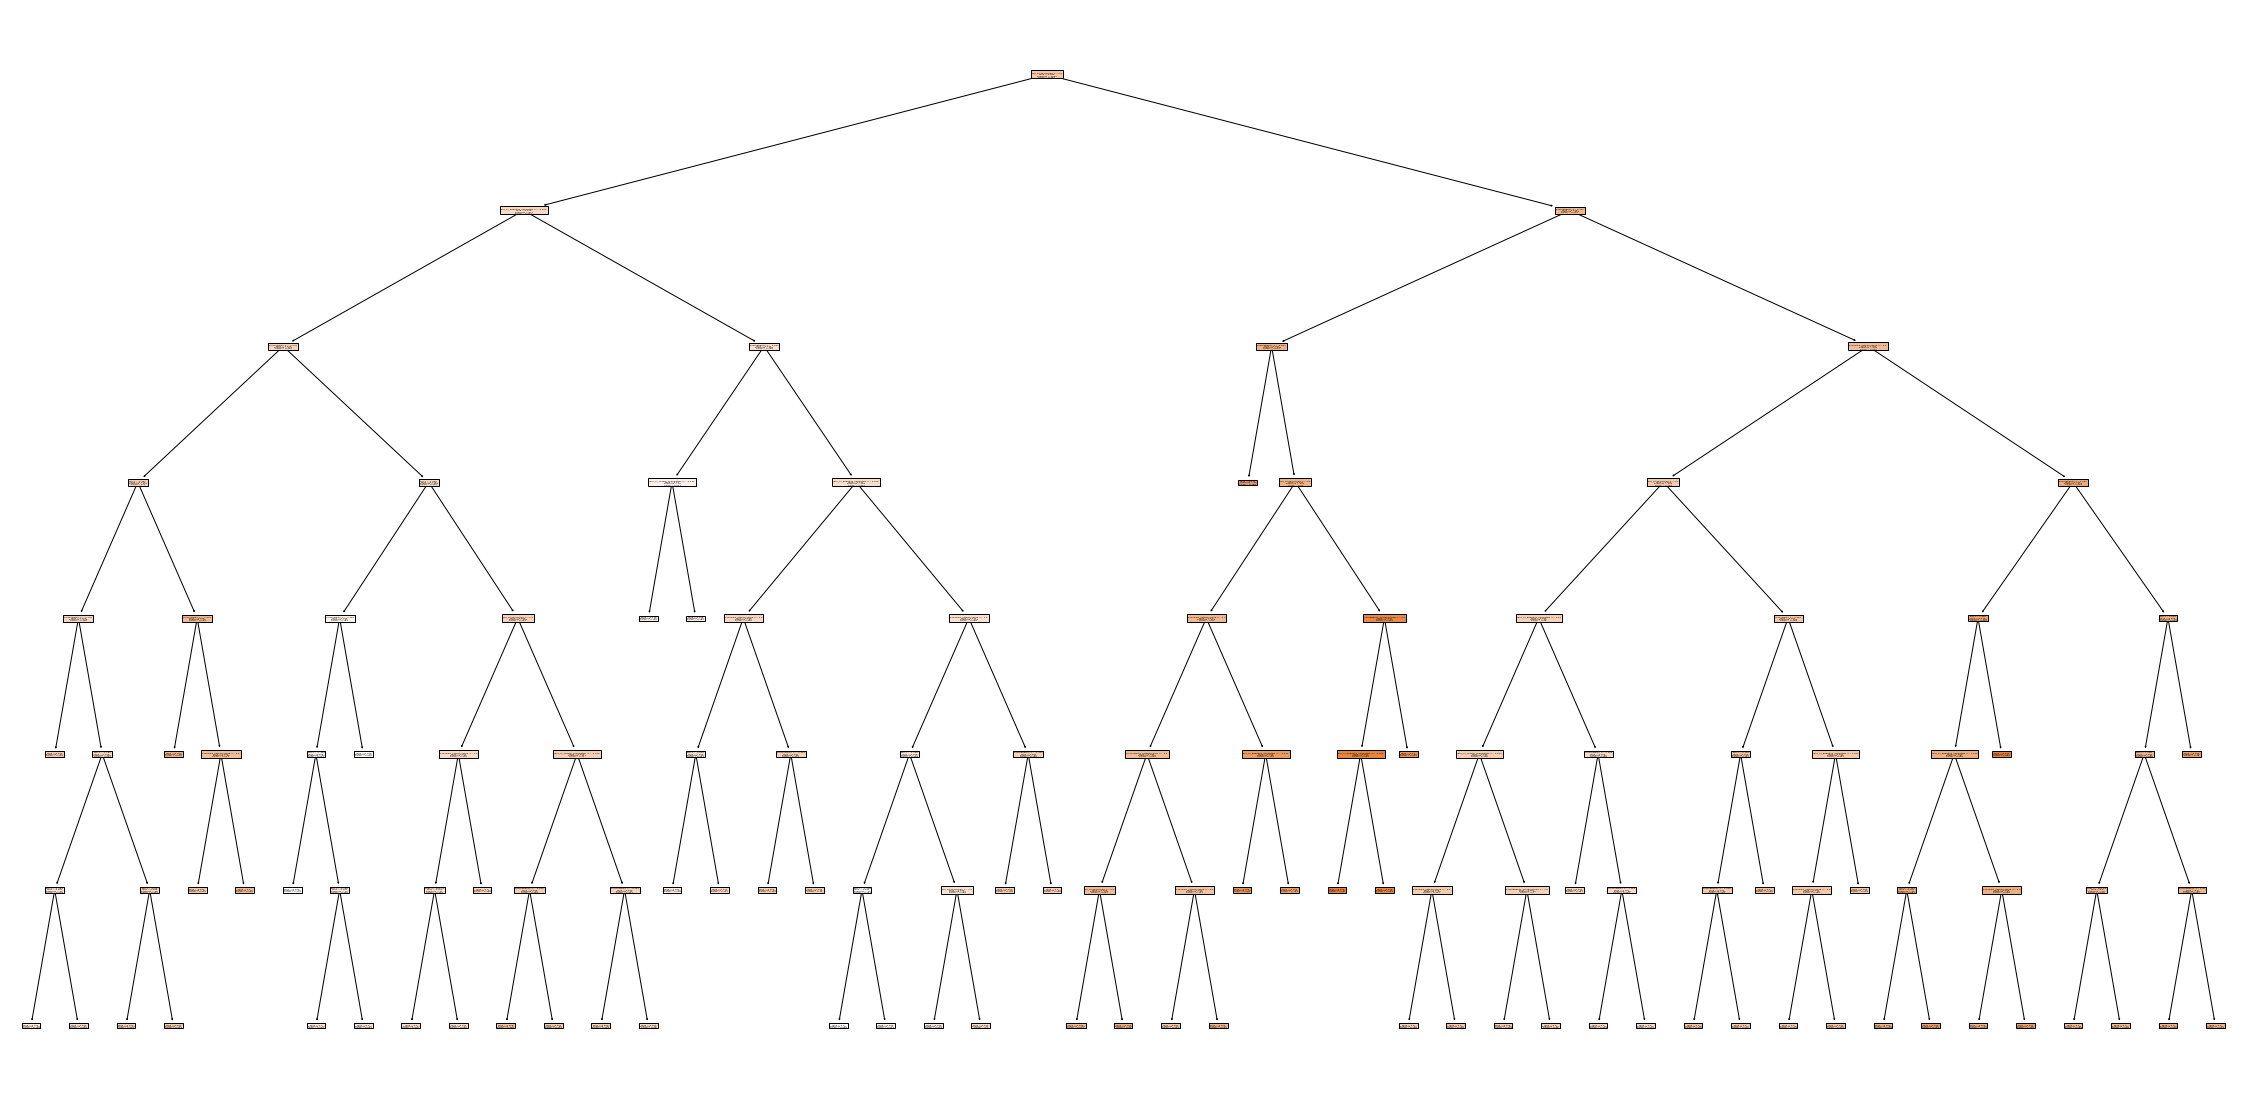

In [36]:
fig_1 = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo_1, feature_names=x_train.columns, filled=True);

In [37]:
y_pred_test_dt3 = mejor_modelo_1.predict(x_test)
y_pred_train_dt3 = mejor_modelo_1.predict(x_train)

In [38]:
dt_results3 = metricas(y_test, y_train, y_pred_test_dt3, y_pred_train_dt3, "Decision tree III")
dt_results3



,MAE,MSE,RMSE,R2,set,modelo
0,0.038126,0.002659,0.051568,0.916709,test,Decision tree III
1,0.032307,0.001975,0.044438,0.940794,train,Decision tree III


In [40]:
df_decision_results = pd.concat([dt_results1, dt_results2,dt_results3], axis = 0)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,1.095147e-02,5.424118e-04,2.328974e-02,0.983011,test,Decission Tree I
1,2.218004e-18,1.745198e-34,1.321059e-17,1.000000,train,Decission Tree I
0,3.198716e-02,1.977779e-03,4.447222e-02,0.938053,test,Decision tree II
1,2.664228e-02,1.431497e-03,3.783513e-02,0.957082,train,Decision tree II
0,3.812551e-02,2.659234e-03,5.156776e-02,0.916709,test,Decision tree III
1,3.230741e-02,1.974749e-03,4.443815e-02,0.940794,train,Decision tree III


El modelo está mas overfitting por lo cual intentamos con otras hiperparametros

In [41]:
param_2 = {"max_depth": [5,6,7,8], # hemos cambiado la profundidad de nuestro arbol y hemos puesto 4 posibilidades mas pequeñas de 9.
        "max_features": [1,2,3], # hemos calculado la raiz cuadrada de las variablñes predictoras y era 3,2 así que nos quedamos con 3 como maximo
        "min_samples_split": [20,50,100], #hemos calculado el numero de filas de nuestro fichero, 1706, por lo cual nos quedamos con un 100 como maximo.
        "min_samples_leaf": [20,50,100]} 

In [42]:
gs_2 = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param_2,
            cv=10, 
            verbose=-1, 
            return_train_score = True, 
            scoring="neg_mean_squared_error") 

In [43]:
gs_2.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [5, 6, 7, 8], 'max_features': [1, 2, 3],
                         'min_samples_leaf': [20, 50, 100],
                         'min_samples_split': [20, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [44]:
mejor_modelo_2 = gs_2.best_estimator_
mejor_modelo_2

DecisionTreeRegressor(max_depth=7, max_features=3, min_samples_leaf=20,
                      min_samples_split=50)

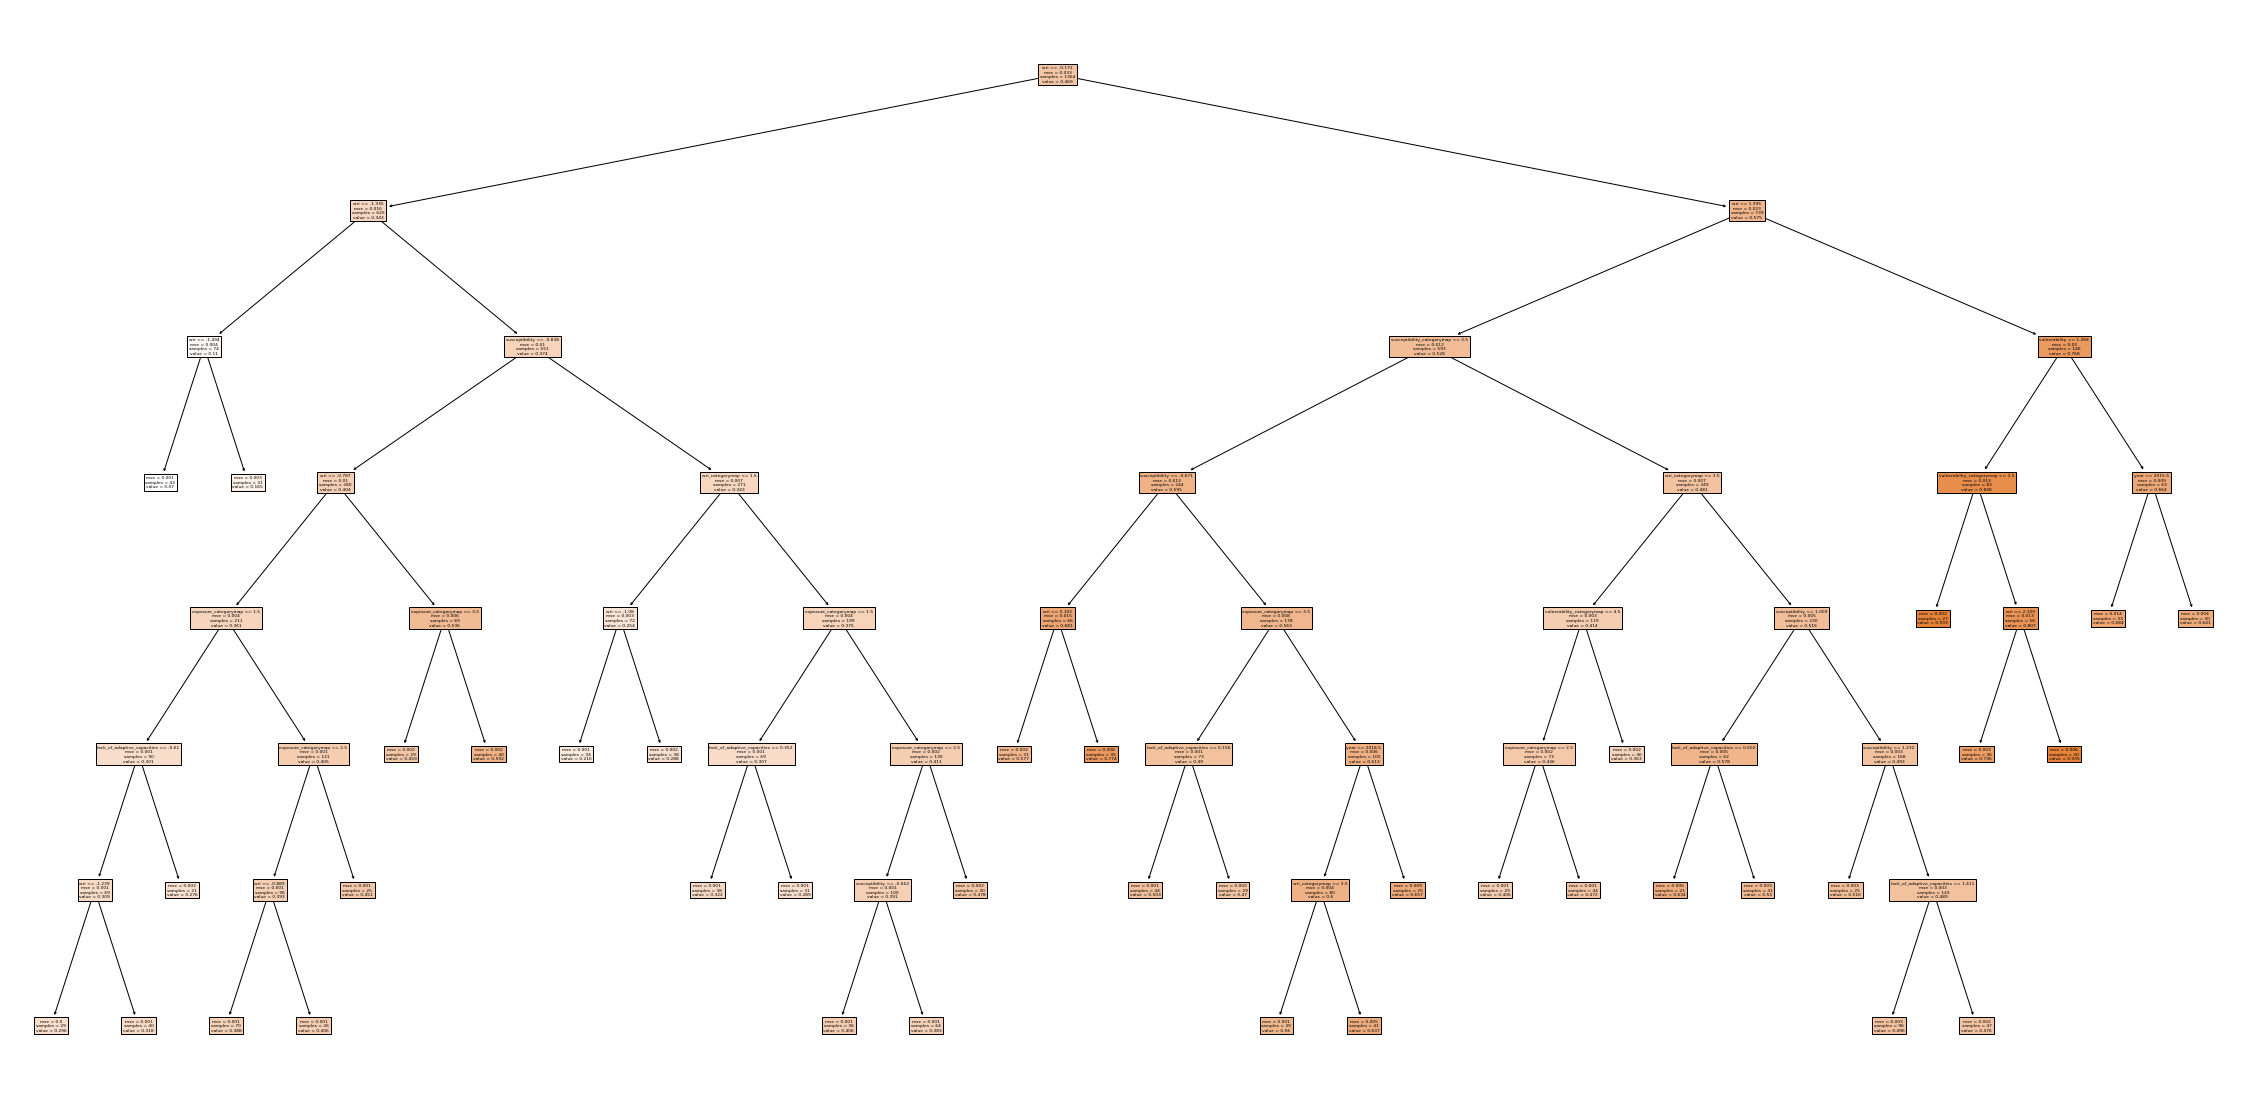

In [45]:
fig_2 = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo_2, feature_names=x_train.columns, filled=True);

In [46]:
y_pred_test_dt4 = mejor_modelo_2.predict(x_test)
y_pred_train_dt4 = mejor_modelo_2.predict(x_train)

In [47]:
dt_results4 = metricas(y_test, y_train, y_pred_test_dt4, y_pred_train_dt4, "Decision tree IV")
dt_results4


,MAE,MSE,RMSE,R2,set,modelo
0,0.042773,0.003462,0.058835,0.891580,test,Decision tree IV
1,0.037594,0.002489,0.049891,0.925372,train,Decision tree IV


In [48]:
df_decision_results = pd.concat([dt_results1, dt_results2,dt_results3,dt_results4], axis = 0)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,1.095147e-02,5.424118e-04,2.328974e-02,0.983011,test,Decission Tree I
1,2.218004e-18,1.745198e-34,1.321059e-17,1.000000,train,Decission Tree I
0,3.198716e-02,1.977779e-03,4.447222e-02,0.938053,test,Decision tree II
1,2.664228e-02,1.431497e-03,3.783513e-02,0.957082,train,Decision tree II
0,3.812551e-02,2.659234e-03,5.156776e-02,0.916709,test,Decision tree III
1,3.230741e-02,1.974749e-03,4.443815e-02,0.940794,train,Decision tree III
0,4.277299e-02,3.461500e-03,5.883452e-02,0.891580,test,Decision tree IV
1,3.759363e-02,2.489136e-03,4.989124e-02,0.925372,train,Decision tree IV


In [49]:
importancia_predictores_2 = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': mejor_modelo_2.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores_2.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores_2

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
0,wri,0.776890
8,exposure_categorymap,0.054942
7,susceptibility_categorymap,0.043973
6,wri_categorymap,0.040865
2,susceptibility,0.036709
1,vulnerability,0.028982
9,vulnerability_categorymap,0.011578
4,lack_of_adaptive_capacities,0.003895
5,year,0.002165
3,lack_of_coping_capabilities,0.000000


/Users/admin/opt/anaconda3/lib/python3.9/site-packages/seaborn/palettes.py:443: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


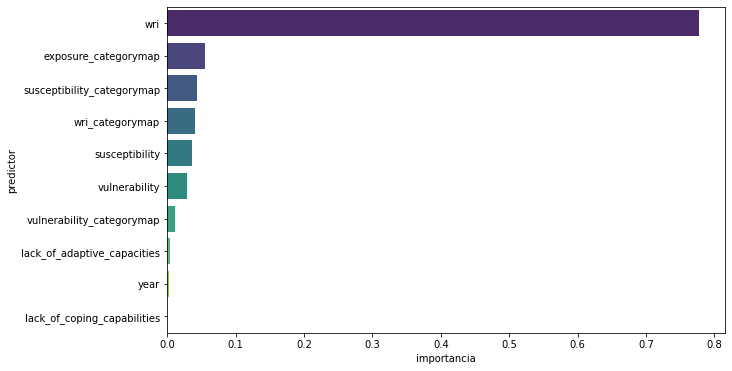

In [51]:
plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores_2, palette="viridis");
plt.show()